# **Setting up the environment**

In [1]:
#############################################################################################################
    #Copyright (c) 2023, 2024 , Prof. Radhamadhab Dalai, ITER , Siksha O Aanusandhan University
    #Odisha, India,
    #Author's email address :  radhamadhabdalai@soa.ac.in
 ########################################################################################################

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import tensorflow as tf


# **Preprocessing image data**

In [3]:
import pickle

with open("input/traffic-sign-classification/german-traffic-signs/train.p", mode='rb') as training_data:
    train = pickle.load(training_data)
with open("input/traffic-sign-classification/german-traffic-signs/valid.p", mode='rb') as validation_data:
    valid = pickle.load(validation_data)
with open("input/traffic-sign-classification/german-traffic-signs/test.p", mode='rb') as testing_data:
    test = pickle.load(testing_data)

In [4]:
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# **Visualizing the images**

23

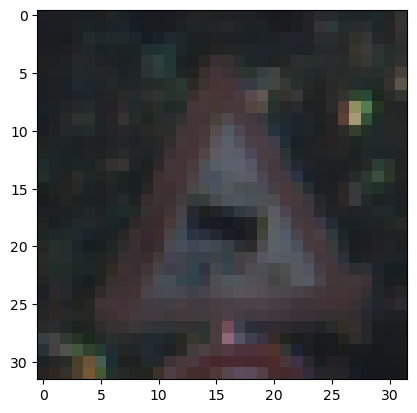

In [5]:
import matplotlib.pyplot as plt

i = 2000
plt.imshow(X_train[i])
y_train[i]

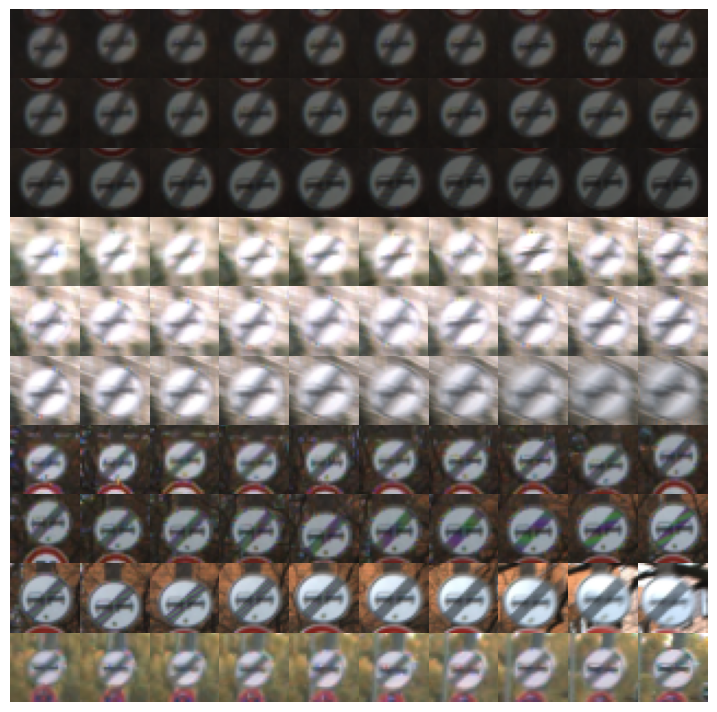

In [6]:
def plot_digit(image_data):
    image = image_data.reshape(32,32,3)
    plt.imshow(image)
    plt.axis("off")

plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X_train[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [7]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

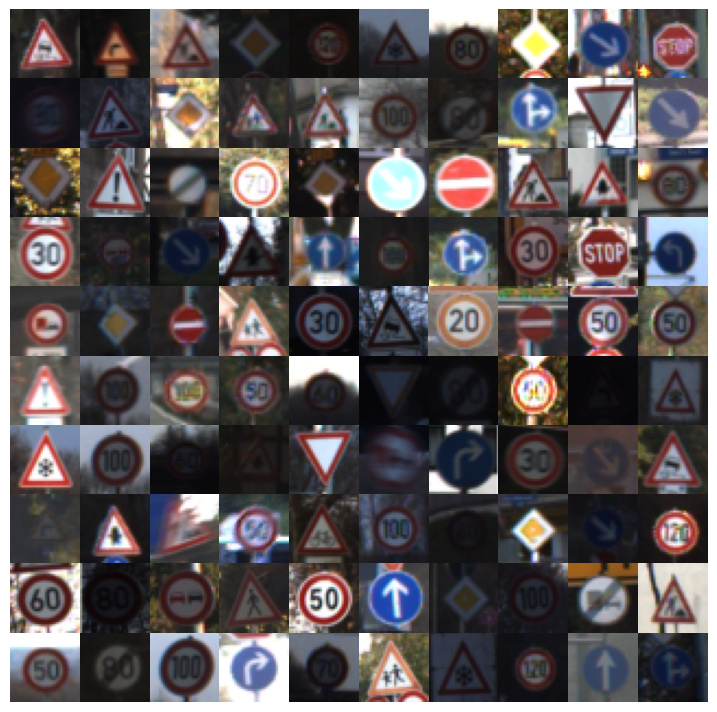

In [8]:
# After shuffling
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X_train[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [9]:
X_train.shape

(34799, 32, 32, 3)

# **ResNet-34 Architecture using Keras**

In [10]:
from functools import partial

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="same", kernel_initializer="he_normal",
                        use_bias=False)

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [11]:
model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[32, 32, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"),
])
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(43, activation="softmax"))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        9408      
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 64)         0         
 )                                                               
                                                                 
 residual_unit (ResidualUnit  (None, 8, 8, 64)         74240     
 )                                                               
                                                        

# **Model Training**

In [13]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)

Epoch 1/10
1088/1088 [==============================] - 96s 47ms/step - loss: 0.9074 - accuracy: 0.7392 - val_loss: 1.0082 - val_accuracy: 0.7304
Epoch 2/10
1088/1088 [==============================] - 49s 45ms/step - loss: 0.1833 - accuracy: 0.9437 - val_loss: 0.5928 - val_accuracy: 0.8290
Epoch 3/10
1088/1088 [==============================] - 50s 46ms/step - loss: 0.1318 - accuracy: 0.9609 - val_loss: 0.4862 - val_accuracy: 0.8746
Epoch 4/10
1088/1088 [==============================] - 50s 46ms/step - loss: 0.0951 - accuracy: 0.9721 - val_loss: 0.6189 - val_accuracy: 0.8410
Epoch 5/10
1088/1088 [==============================] - 49s 45ms/step - loss: 0.0908 - accuracy: 0.9726 - val_loss: 0.4848 - val_accuracy: 0.8823
Epoch 6/10
1088/1088 [==============================] - 49s 45ms/step - loss: 0.0641 - accuracy: 0.9807 - val_loss: 0.7358 - val_accuracy: 0.8358
Epoch 7/10
1088/1088 [==============================] - 49s 45ms/step - loss: 0.0559 - accuracy: 0.9834 - val_loss: 0.3701 -

In [14]:
print('Test Accuracy : {:.4f} %'.format(score[1]*100))

Test Accuracy : 90.7680 %


# **Error analysis**

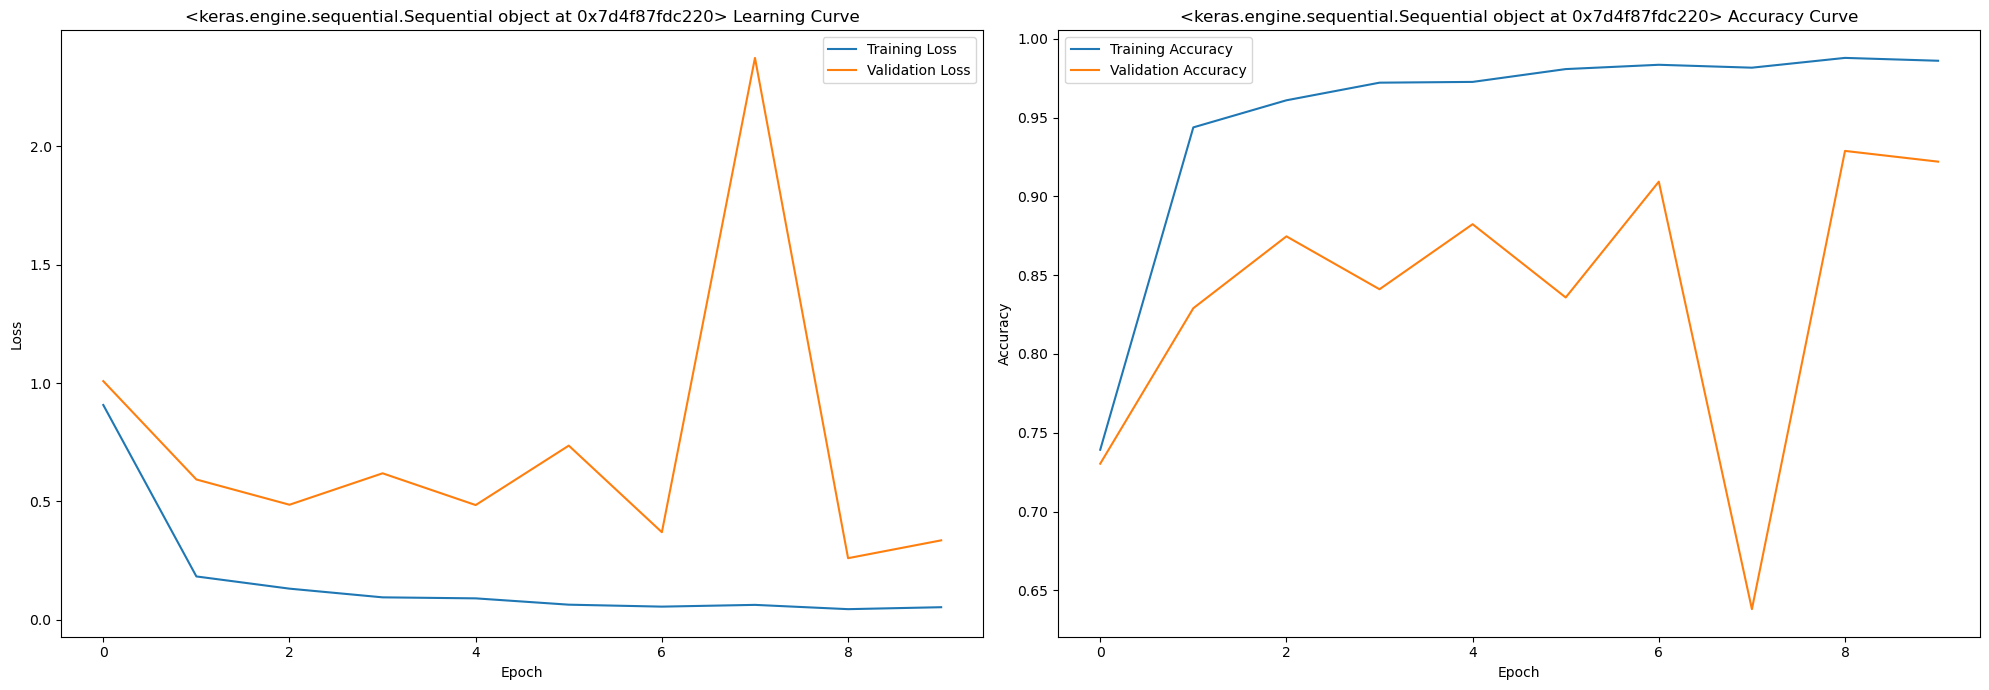

In [15]:
def plot_learning_curves(history, model_name, ax):
    ax.plot(history.history['loss'], label='Training Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    ax.set_title(f'{model_name} Learning Curve')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()

def plot_accuracy_curves(history, model_name, ax):
    ax.plot(history.history['accuracy'], label='Training Accuracy')
    ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax.set_title(f'{model_name} Accuracy Curve')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()

fig, axs = plt.subplots(1, 2, figsize=(20, 7))  
plot_learning_curves(history, model, axs[0])
plot_accuracy_curves(history, model, axs[1])

plt.tight_layout()
plt.show()
